# Physiobank

_"PhysioBank is a large and growing archive of well-characterized digital recordings of physiologic signals and related data for use by the biomedical research community. PhysioBank currently includes databases of multi-parameter cardiopulmonary, neural, and other biomedical signals from healthy subjects and patients with a variety of conditions with major public health implications, including sudden cardiac death, congestive heart failure, epilepsy, gait disorders, sleep apnea, and aging."_

O conjunto de dados utilizados nessa análise é o [CHB-MIT Scalp EEG Database](https://www.physionet.org/physiobank/database/chbmit/). Os dados podem ser baixados no [Lief](lief.if.ufrgs.br/pub/EEG/physionet/), consisitindo em
>EEG recordings of 22 pediatric subjects with intractable seizures, monitored for up to several days following withdrawal of anti-seizure medication to characterize their seizures and assess their candidacy for surgical intervention. In all, the onsets and ends of 182 seizures are annotated.

O physionet possui outros dados [neuroelétricos e mioelétricos](https://www.physionet.org/physiobank/database/#neuro), mas nenhum de pacientes saudáveis em resting state.

## Arquivos edf

Os dados do chbmit estão em formato _.edf_. Para ler esses arquivos o python utiliza o pacote [pyedflib](http://pyedflib.readthedocs.io/en/latest/)

As simulações abaixo são executadas no diretório correla, que por sua vez está no mesmo diretório dos dados dos pacientes. Como sempre, o _pattern_ pode ser modificado para refletir a estrutura de diretórios de cada usuário. A execução dos comandos `ls` abaixo explicita a estrutura, `chb??` são as pastas com os dados.

In [1]:
!ls

analisa.py   corr.dat	      correla_fase.py~	surrogates.py	Untitled.ipynb
analisa.py~  correla_fase.py  __pycache__	surrogates.py~


In [2]:
!ls ../

 ANNOTATORS   chb08   chb16   chb24	     RECORDS
 chb01	      chb09   chb17  '#corr.dat#'    RECORDS-WITH-SEIZURES
 chb02	      chb10   chb18   correla	     SHA1SUMS
 chb03	      chb11   chb19   DOI	     SHA256SUMS
 chb04	      chb12   chb20   HEADER.shtml   shoeb-icml-2010.pdf
 chb05	      chb13   chb21   leedf.py	     SUBJECT-INFO
 chb06	      chb14   chb22   local.css
 chb07	      chb15   chb23   MD5SUMS


#### Sumário

Cada pasta contém um sumário apresentando as informações de cada conjunto de dados


In [3]:
!head -40 ../chb01/chb01-summary.txt

Data Sampling Rate: 256 Hz
*************************

Channels in EDF Files:
**********************
Channel 1: FP1-F7
Channel 2: F7-T7
Channel 3: T7-P7
Channel 4: P7-O1
Channel 5: FP1-F3
Channel 6: F3-C3
Channel 7: C3-P3
Channel 8: P3-O1
Channel 9: FP2-F4
Channel 10: F4-C4
Channel 11: C4-P4
Channel 12: P4-O2
Channel 13: FP2-F8
Channel 14: F8-T8
Channel 15: T8-P8
Channel 16: P8-O2
Channel 17: FZ-CZ
Channel 18: CZ-PZ
Channel 19: P7-T7
Channel 20: T7-FT9
Channel 21: FT9-FT10
Channel 22: FT10-T8
Channel 23: T8-P8

File Name: chb01_01.edf
File Start Time: 11:42:54
File End Time: 12:42:54
Number of Seizures in File: 0

File Name: chb01_02.edf
File Start Time: 12:42:57
File End Time: 13:42:57
Number of Seizures in File: 0

File Name: chb01_03.edf


In [4]:
import pyedflib

file = '../chb01/chb01_02.edf'
clip = pyedflib.EdfReader(file)

Mais informações sobre a classe EDFReader podem ser obtidas com `help(clip)`

### Análise

A função `correla(pattern, size=None, norm=True, array=True, correlation=True)`, no arquivo _correla_fase.py_ retorna as correlações entre os sinais, como na análise dos dados do kaggle.

#### Atenção
O argumento `size`, que não existia nas funções do kaggle, permite que seja selecionado apenas uma parte do arquivo. Recomendado para analises preliminares, para obter o resultado rapidamente.

Os tempos necessários para rodar a correlação com $1$ s, $30$ s e $60$ s são:

In [5]:
%%time
from correla_fase import correla

pattern = '../chb01/*01.edf'
corr, tau = correla(pattern,256)

CPU times: user 248 ms, sys: 12.9 ms, total: 261 ms
Wall time: 261 ms


In [6]:
%%time
from correla_fase import correla

pattern = '../chb01/*01.edf'
corr, tau = correla(pattern,30*256)

CPU times: user 40.9 s, sys: 12.3 ms, total: 40.9 s
Wall time: 41 s


In [7]:
%%time
from correla_fase import correla

pattern = '../chb01/*01.edf'
corr, tau = correla(pattern,60*256)

CPU times: user 2min 46s, sys: 88.8 ms, total: 2min 46s
Wall time: 2min 46s


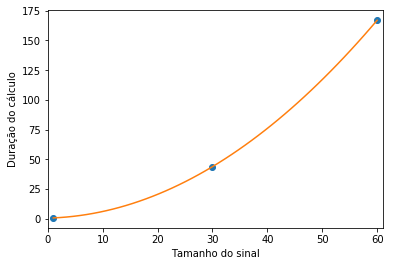

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = [1, 30, 60]
y = [0.635, 43.8, 167]

z = np.polyfit(x, y, 2)
f = np.poly1d(z)

x_new = np.linspace(x[0], x[-1], 50)
y_new = f(x_new)

plt.plot(x,y,'o', x_new, y_new)
plt.xlim([x[0]-1, x[-1] + 1 ])
plt.xlabel('Tamanho do sinal')
plt.ylabel('Duração do cálculo')
plt.show()

In [9]:
print('A duração do cálculo de correlação escala com' + str(z[-1]) + '*t^2')
print('O tempo necessário para calcular a correlação de sinais de uma hora é ' + str(f(3600)/3600) + ' horas')

A duração do cálculo de correlação escala com0.47784921098779604*t^2
O tempo necessário para calcular a correlação de sinais de uma hora é 159.86860536398487 horas


Parece um ótimo momento para exercitar as técnicas de programação em paralelo, não? Imaginem que delícia calcular a correlação cruzada com 100 surrogates...

Consideraremos, a seguir, sinais de um minuto

In [10]:
corr.shape

(1, 23, 23)

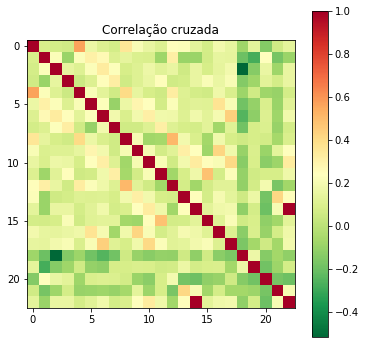

In [11]:
import matplotlib.colors as clr

#extent=[1,23,1,23]
plt.figure(figsize=(6,6))
plt.imshow(corr[0], cmap='RdYlGn_r')
plt.colorbar()
plt.title('Correlação cruzada')
plt.show()

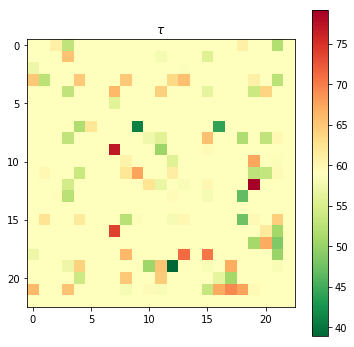

In [12]:
plt.figure(figsize=(6,6))
plt.imshow(tau[0], cmap='RdYlGn_r')
plt.colorbar()
plt.title(r'$\tau$')
plt.show()

In [13]:
clip._close()
del clip

## Surrogates

In [14]:
from surrogates import surrogates, iaaft, mod

pattern = '../chb01/chb01_02.edf'
n_sur = 10 #numero de surrogates
n_iter = 1000 #numero de iterações do iaaft
sur = surrogates(pattern,n_sur,n_iter,60*256)

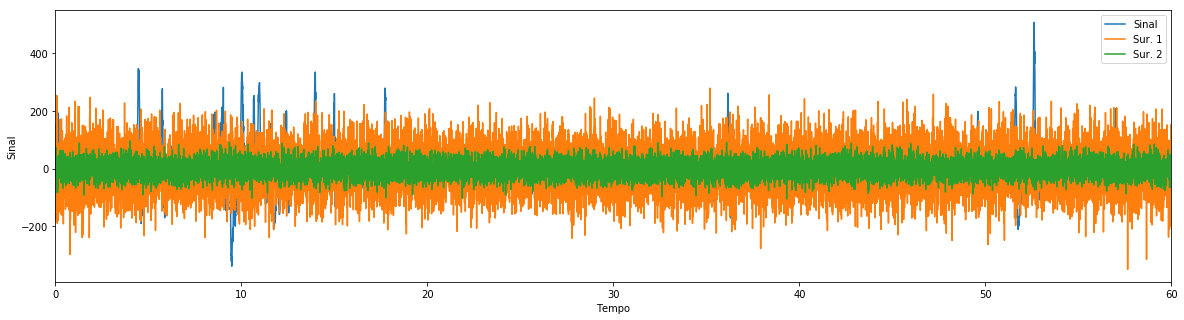

In [17]:
x=np.arange(0.0,60.0,1/256)
plt.figure(figsize=(20,5))
plt.plot(x,sur[0][0],label='Sinal')
plt.plot(x,sur[0][1],label='Sur. 1')
plt.plot(x,sur[0][2],label='Sur. 2')
#plt.plot(x,sur[0][3],label='Sur. 3')
plt.legend()
plt.xlabel('Tempo')
plt.ylabel('Sinal')
plt.xlim(0,60)
plt.show()